<a href="https://colab.research.google.com/github/Carine-Tan/Carine-Tan.github.io/blob/master/Model_Selection_Stroke_Prognosis_(feature_engineering).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Identify patients at high risk for stroke based on their demographic, behavioral and medical risk factors.

# Model Selection

## Objective - To predict stroke with the best model

In [ ]:
# install sklearn ver.24
!pip install scikit-learn==0.24.1

In [ ]:
# install imbalanced learn for SMOTE use
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.7/dist-packages (0.8.0)


In [ ]:
!pip install git+https://github.com/remykarem/mixed-naive-bayes#egg=mixed-naive-bayes

### Import required libraries

In [ ]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix , classification_report, f1_score,\
                            accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# arbituary value for SEED
SEED = 42

### Step 1: Load in the required data

In [ ]:
# Load the dataset in pandas dataframe
df_data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df_data.sample(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
606,7446,Male,44.0,0,0,Yes,Private,Urban,83.51,31.2,never smoked,0
2786,54371,Male,78.0,0,0,Yes,Govt_job,Urban,143.47,27.6,formerly smoked,0
2638,8616,Female,50.0,0,0,Yes,Private,Rural,68.41,23.9,smokes,0
863,16809,Male,41.0,0,0,Yes,Private,Urban,111.71,38.9,formerly smoked,0
172,67432,Female,60.0,0,0,Yes,Private,Urban,97.43,26.4,smokes,1


In [ ]:
df_data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

### Step 2: Data Pre-processing and Exploratory Data Analysis

#### Conventional EDA Codings

In [ ]:
# Print a concise summary of df_data DataFrame.
df_data.info()
# Observation: there are null values in bmi column 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [ ]:
# Let us first clean our data
# 1) Look for any missing values
df_data.isna().any()

id                   False
gender               False
age                  False
hypertension         False
heart_disease        False
ever_married         False
work_type            False
Residence_type       False
avg_glucose_level    False
bmi                   True
smoking_status       False
stroke               False
dtype: bool

In [ ]:
# 2) Since the ID column is unique, we will drop the column
df_data = df_data.drop(['id'], axis=1)
# 3) Drop 1 patient who is categorized as ‘Other’ in the gender column.
df_data = df_data[df_data['gender'] != 'Other']

In [ ]:
# 4) Replace the missing values with mean of bmi attribute
df_data['bmi'].fillna(np.round(df_data['bmi'].mean(), 1), inplace = True)

### Let's analyze the data further and see how the independent variables are related to stroke.

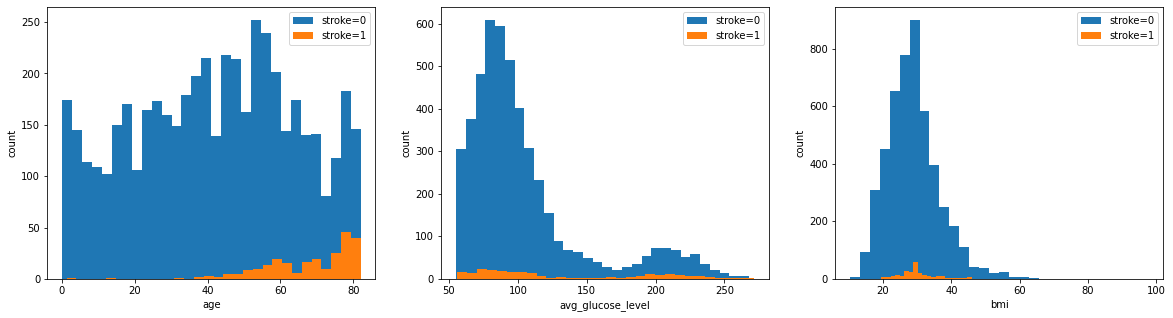

In [ ]:
# Lets look at the continuous variables and their impact on stroke.

cvars = ['age', 'avg_glucose_level', 'bmi']
fig,ax = plt.subplots(1,3,figsize=(20,5))

for i,x in enumerate(cvars):
    ax[i].hist(df_data[x][df_data['stroke']==0],label='stroke=0',bins=30)
    ax[i].hist(df_data[x][df_data['stroke']==1],label='stroke=1',bins=30)
    ax[i].set(xlabel=x,ylabel='count')
    ax[i].legend()

In [ ]:
df_data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
# Function to create 100% stacked bar chart
def get_100_percent_stacked_bar_chart(column, width = 0.5):
    # Get the count of records by column and stroke
    df_breakdown = df_data.groupby([column, 'stroke'])['age'].count()
    # Get the count of records by gender
    df_total = df_data.groupby([column])['age'].count()
    # Get the percentage for 100% stacked bar chart
    df_pct = df_breakdown / df_total * 100
    # Create proper DataFrame's format
    df_pct = df_pct.unstack()
    return df_pct.plot.bar(stacked=True, figsize=(6,6), width=width);

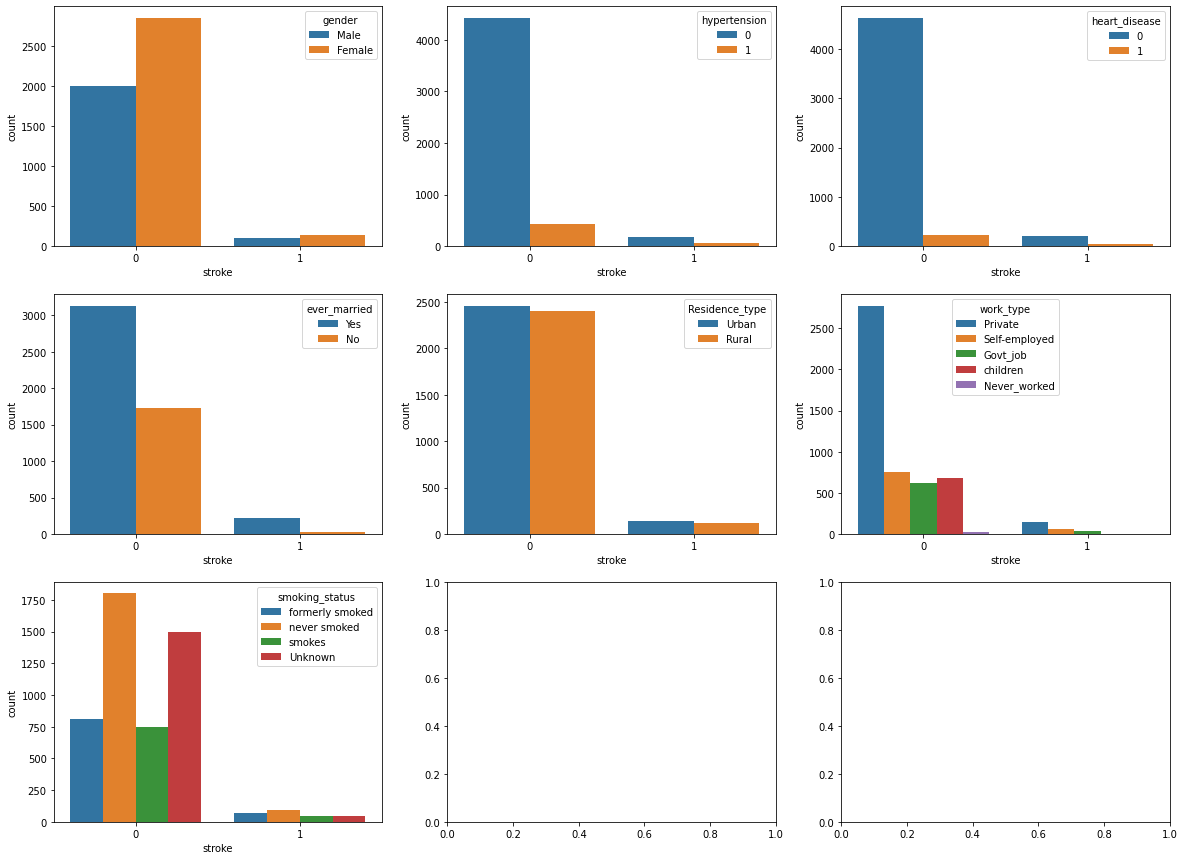

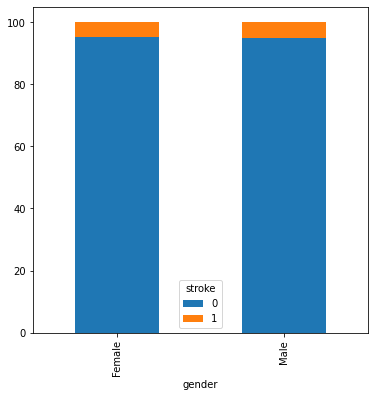

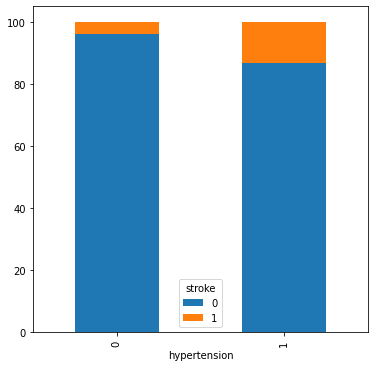

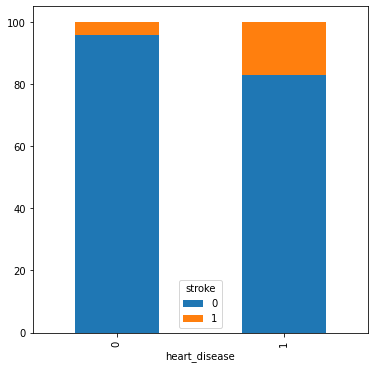

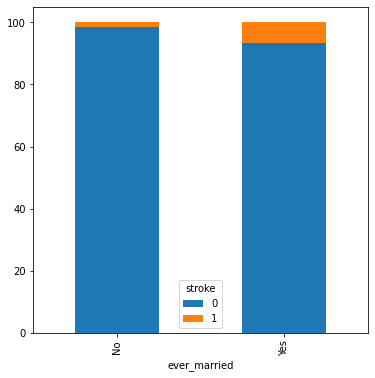

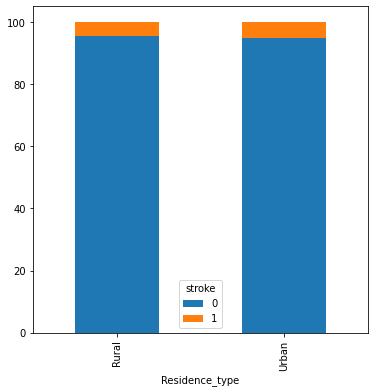

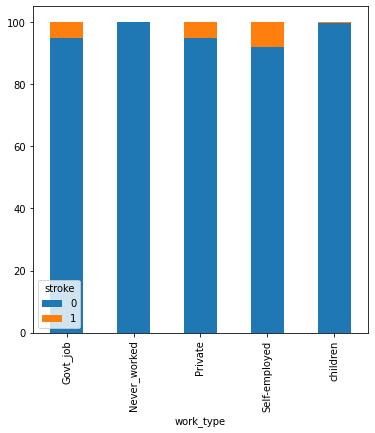

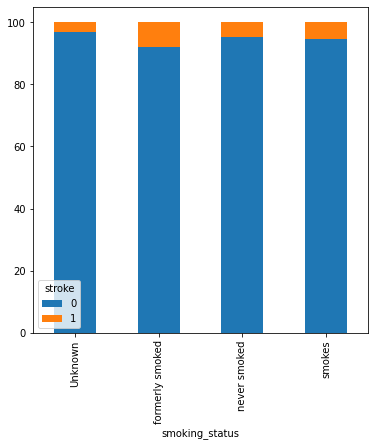

In [ ]:
# Let's look at all the categorical variables, their distribution and impact on stroke

categorical_var = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type', 'work_type', 'smoking_status']

fig ,ax = plt.subplots(3,3,figsize=(20,15))
for axi ,var in zip(ax.flat,categorical_var):
    sns.countplot(x=df_data.stroke,hue=df_data[var],ax=axi)
    get_100_percent_stacked_bar_chart(var)

#### Convert categorical variables into dummy/indicator variables

In [ ]:
# 4) Encoding the data - Before training the model, we need to make sure the data is in a form that the model can understand
# Use Label Encoder for all features with 2 classes
le = LabelEncoder()
for x in [i for i in df_data.columns if len(df_data[i].unique())==2]:
    print(x, df_data[x].unique())
    df_data[x]= le.fit_transform(df_data[x])

gender ['Male' 'Female']
hypertension [0 1]
heart_disease [1 0]
ever_married ['Yes' 'No']
Residence_type ['Urban' 'Rural']
stroke [1 0]


In [ ]:
# 5) Encode variables with more than 2 Classes
df = pd.get_dummies(df_data, columns= [i for i in df_data.columns if df_data[i].dtypes=='object'])  #drop_first=True

In [ ]:
df.head()

,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1,67.0,0,1,1,1,228.69,36.6,1,0,0,1,0,0,0,1,0,0
1,0,61.0,0,0,1,0,202.21,28.9,1,0,0,0,1,0,0,0,1,0
2,1,80.0,0,1,1,0,105.92,32.5,1,0,0,1,0,0,0,0,1,0
3,0,49.0,0,0,1,1,171.23,34.4,1,0,0,1,0,0,0,0,0,1
4,0,79.0,1,0,1,0,174.12,24.0,1,0,0,0,1,0,0,0,1,0


In [ ]:
# limit to numerical data using df.select_dtypes()
# all features converted to numerical
df_num = df.select_dtypes(include=['number'])
df_num.nunique()

gender                               2
age                                104
hypertension                         2
heart_disease                        2
ever_married                         2
Residence_type                       2
avg_glucose_level                 3978
bmi                                418
stroke                               2
work_type_Govt_job                   2
work_type_Never_worked               2
work_type_Private                    2
work_type_Self-employed              2
work_type_children                   2
smoking_status_Unknown               2
smoking_status_formerly smoked       2
smoking_status_never smoked          2
smoking_status_smokes                2
dtype: int64

#### Imbalanced Target Variable

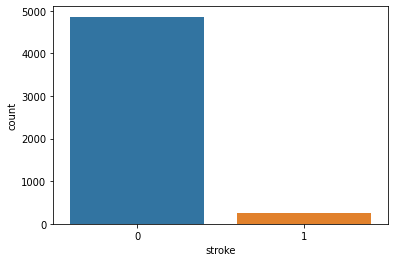

In [ ]:
# To visualize how well balanced the target (dependent) variable is
## This is moderate imbalanced.
_ = sns.countplot(x=df['stroke'])

### Feature Engineering

#### Feature Engineering - Adding interaction terms

In [ ]:
# Interaction Terms

# (1) Long-term Stress Factor: marriage + work_type + smoking_status * age
# Results: Didn't improve the classification results, eliminated
# df['stress'] = (df['ever_married'] + df['work_type_Self-employed'] + df['smoking_status_smokes'])* df['age']

# (2) Stress: marriage + work_type + smoking_status
# Results: slight improvement to f1-score for prediction:1
df['stress'] = (df['ever_married'] + df['work_type_Self-employed'] + df['smoking_status_smokes'])

# (3) Hypertension coupled Heart Disease: hypertension * heart_disease
# Results: Didn't improve the classification results from #(2)
df['HypTension_HeartDisease'] = df['hypertension'] * df['heart_disease']

# (4) Diabetes coupled BMI: (avg_glucose_level * Gender) / bmi
# Results: slight improvement in f1-score for prediction:0 from #(3)
# df['Diabetes_bmi'] = (df['avg_glucose_level'] + df['gender']) / df['bmi']

# (5) Stress Threshold by Gender: marriage + work_type + smoking_status + gender
# Results: Didn't improve the classification results from #(4)
# df['stress_gender'] = df['ever_married_Yes'] + df['work_type_Self-employed'] + df['smoking_status_smokes'] + df['gender']

# rearrange columns
df_stroke = df['stroke']
df = df.drop(['stroke'], axis=1)
df['stroke'] = df_stroke

#### Filter Features by Variance

In [ ]:
# Drop low variance variables.  
df.var()

gender                               0.242647
age                                511.373788
hypertension                         0.087991
heart_disease                        0.051114
ever_married                         0.225617
Residence_type                       0.249983
avg_glucose_level                 2050.731557
bmi                                 59.262825
work_type_Govt_job                   0.112081
work_type_Never_worked               0.004288
work_type_Private                    0.244817
work_type_Self-employed              0.134634
work_type_children                   0.116410
smoking_status_Unknown               0.210921
smoking_status_formerly smoked       0.143117
smoking_status_never smoked          0.233231
smoking_status_smokes                0.130609
stress                               0.593131
HypTension_HeartDisease              0.012372
stroke                               0.046371
dtype: float64

In [ ]:
# drop low variance feature ['work_type_Never_worked']
# noted slight improvement in classification report
df = df.drop('work_type_Never_worked', axis=1)

In [ ]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job',
       'work_type_Private', 'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes', 'stress',
       'HypTension_HeartDisease', 'stroke'],
      dtype='object')

#### Filter Features by High Correlation

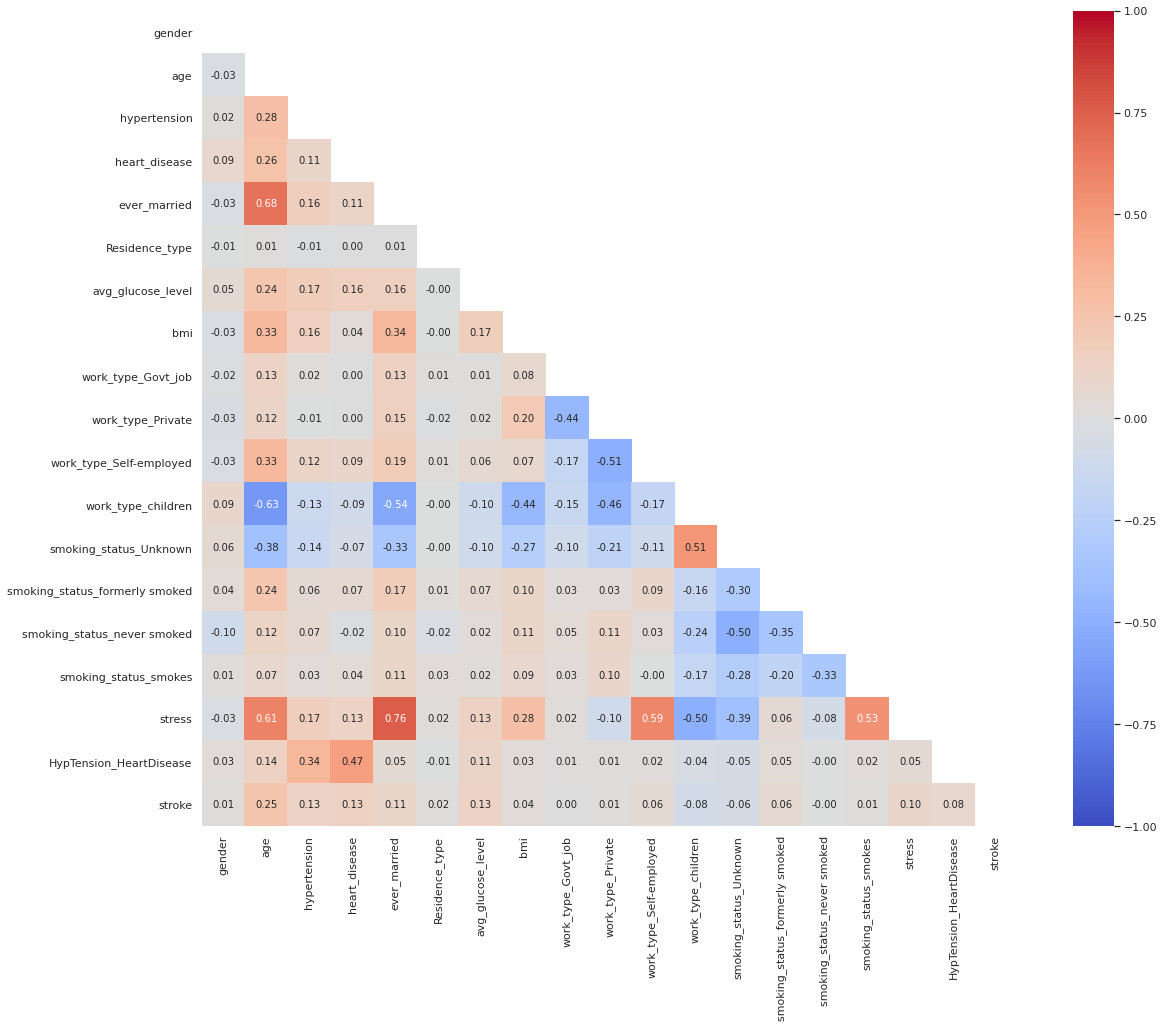

In [ ]:
# correlation matrix heatmap visualization
# Identify highly correlated features, threshold: >0.65
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(df.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,15))

# Plot the heatmap
_ = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={"size": 10}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')  # annot=True display corr label

# _ = sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, square=True, 
#                 cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')

# Prevent Heatmap Cut-Off Issue
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom+0.5, top-0.5)

In [ ]:
# look at correlations in the numerical independent variables, as well as the dependent variable ('stroke')
abs(df.corr()["stroke"]).sort_values(ascending=False)

stroke                            1.000000
age                               0.245239
heart_disease                     0.134905
avg_glucose_level                 0.131991
hypertension                      0.127891
ever_married                      0.108299
stress                            0.100590
work_type_children                0.083888
HypTension_HeartDisease           0.080759
smoking_status_formerly smoked    0.064683
work_type_Self-employed           0.062150
smoking_status_Unknown            0.055924
bmi                               0.038936
Residence_type                    0.015415
work_type_Private                 0.011927
gender                            0.009081
smoking_status_smokes             0.008920
smoking_status_never smoked       0.004163
work_type_Govt_job                0.002660
Name: stroke, dtype: float64

In [ ]:
# drop high correlation, threshold >0.65 ['ever_married']
df = df.drop('ever_married', axis=1)

In [ ]:
# Visualize correlations drilled down by dependent variable
# hue : name of variable in data. Variable in data to map plot aspects to different colors.
# Not suitable for binary variables.
# _ = sns.pairplot(df, corner=True, hue='stroke')

### Step 6: Feature Importance & SelectKBest from Step#5

In [ ]:
# Select the top10 important features
df = df[
['gender',
 'age',
 'Residence_type',
 'avg_glucose_level',
 'work_type_Govt_job',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'smoking_status_Unknown',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'HypTension_HeartDisease',
 'stroke']]

### SMOTE: Oversample Imbalance Target Variable
Use SMOTE to create oversampling of data with Class balance - 50:50

In [ ]:
df = df.dropna()
df.isna().any().any()

False

In [ ]:
X=df.drop('stroke',axis=1)  # input
y=df['stroke']              # output (dependent variable)

In [ ]:
from imblearn.over_sampling import SMOTE 

sm = SMOTE(random_state=42)

# create new samples in order that the class balance is perfect – 50:50. 
X_sm, y_sm = sm.fit_resample(X, y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sm.shape}
Shape of y after SMOTE: {y_sm.shape}''')

print('\nBalance of positive and negative classes (%):')
y_sm.value_counts(normalize=True) * 100

Shape of X before SMOTE: (5109, 13)
Shape of X after SMOTE: (9720, 13)
Shape of y after SMOTE: (9720,)

Balance of positive and negative classes (%):


1    50.0
0    50.0
Name: stroke, dtype: float64

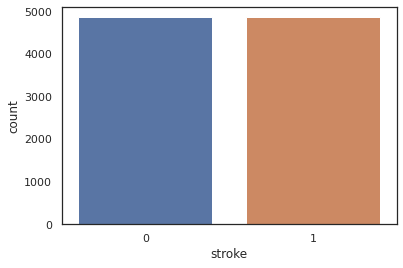

In [ ]:
_ = sns.countplot(x=y_sm)

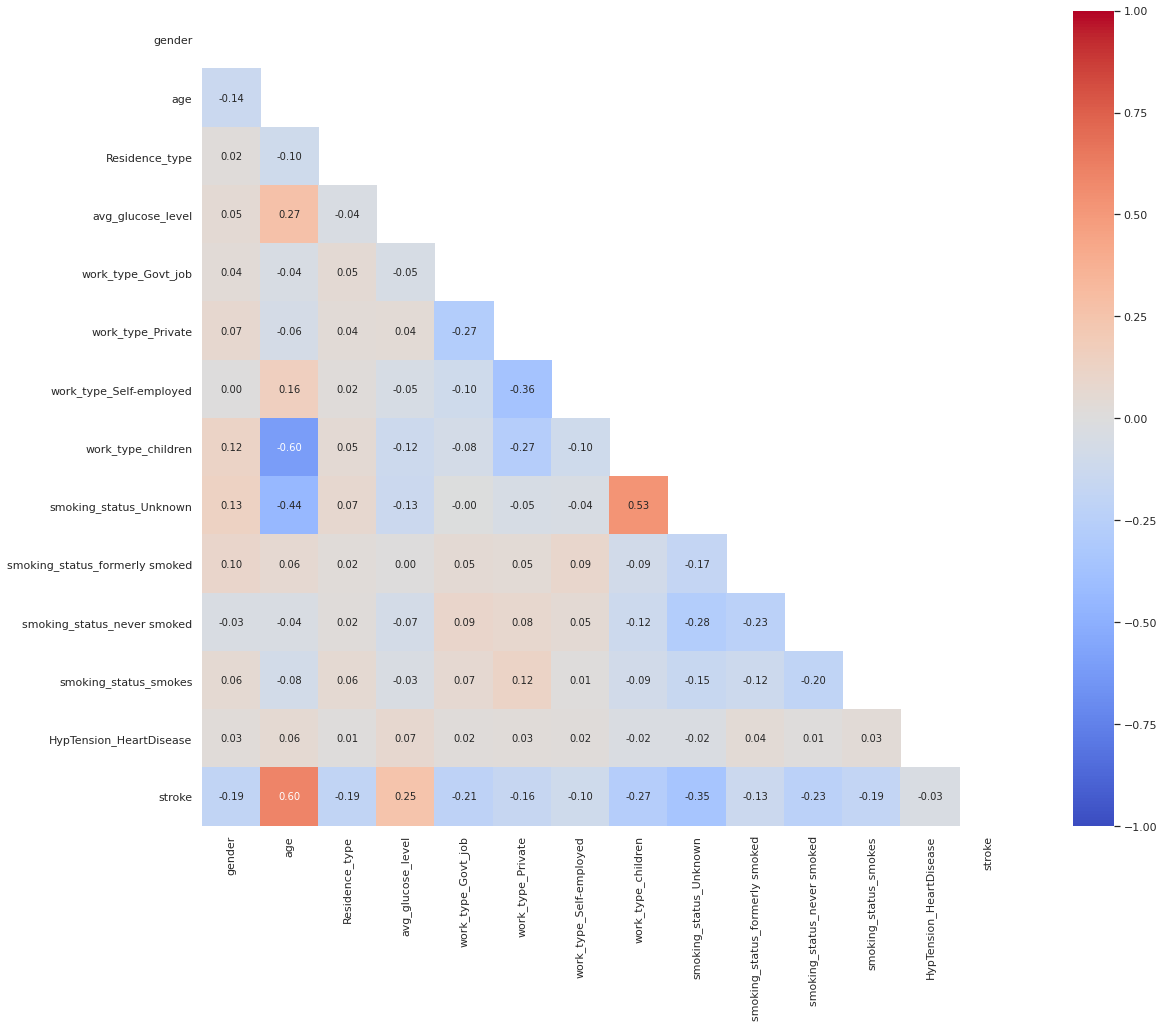

In [ ]:
# correlation matrix heatmap visualization
# Identify highly correlated features, threshold: >0.65
sns.set(style="white")

merged = X_sm
merged['stroke'] = y_sm

# Generate a mask for the upper triangle
matrix = np.triu(merged.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(20,15))

# Plot the heatmap
_ = sns.heatmap(merged.corr(), mask=matrix, annot=True, annot_kws={"size": 10}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')  # annot=True display corr label

# _ = sns.heatmap(df.corr(), annot=True, annot_kws={"size": 12}, square=True, 
#                 cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f')

# Prevent Heatmap Cut-Off Issue
# bottom, top = ax.get_ylim()
# ax.set_ylim(bottom+0.5, top-0.5)

### Step 3: Split the data and train the models

1) Divide our independent and dependent variable into two separate variables.

2) Split the data into training and testing datasets.

In [ ]:
# Splitting our data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sm ,y_sm, 
                                                    test_size = 0.25, 
                                                    shuffle=True, 
                                                    stratify=y_sm,
                                                    random_state=SEED)

#### Feature scaling: MinMaxScaler 

In [ ]:
# MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

to_scale = X_train.columns
mms = MinMaxScaler()
train_scaled = mms.fit_transform(X_train)
X_train_scaled = pd.DataFrame(train_scaled, columns=to_scale)
test_scaled = mms.transform(X_test)
X_test_scaled = pd.DataFrame(test_scaled, columns=to_scale)

#### Baseline model using Logistic Regression

In [ ]:
logreg = LogisticRegression()

In [ ]:
# K-fold cross validation using F1-score as scorer
scores = cross_val_score(logreg, 
                         X_train_scaled, 
                         y_train, 
                         cv=5, 
                         scoring='f1_macro')
print('F1 scores:', scores)
print('Mean & standard deviation: {:.2} {:.2f}'.format(scores.mean(), np.std(scores)))

F1 scores: [0.91277025 0.91477736 0.91621716 0.91348648 0.9230846 ]
Mean & standard deviation: 0.92 0.00


#### Model Selection - Train and evaluate multiple models

In [ ]:
# Lists to keep track of model metrics
models = []
precision_list = []
recall_list = []
f1_score_list = []
training_acc_list = []
testing_acc_list = []
false_negative_list = []

##### Logistic Regression

In [ ]:
# Logistic Regression
logreg = LogisticRegression(n_jobs=-1)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],
              'C': np.logspace(-2, 2, 5)}

gs_logreg = GridSearchCV(logreg,
                      param_grid, 
                      cv=5,
                      scoring='f1_macro',
                      #scoring='roc_auc_ovr',
                      n_jobs=-1)
gs_logreg.fit(X_train_scaled, y_train)

CPU times: user 538 ms, sys: 83.5 ms, total: 621 ms
Wall time: 6.14 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.90101075        nan 0.91526338        nan 0.9129974
        nan 0.91526338        nan 0.91606717        nan 0.91526338
        nan 0.91635596        nan 0.91526338        nan 0.91553789
        nan 0.91526338]
  category=UserWarning


In [ ]:
# Best model hyperparameters and score
print(gs_logreg.best_estimator_)
print(gs_logreg.best_params_)
print(gs_logreg.best_score_)

LogisticRegression(C=10.0, n_jobs=-1)
{'C': 10.0, 'penalty': 'l2'}
0.9163559633575231


In [ ]:
# Using best estimator found by GridSearchCV
logreg = gs_logreg.best_estimator_
logreg.fit(X_train_scaled, y_train)

LogisticRegression(C=10.0, n_jobs=-1)

In [ ]:
y_pred = logreg.predict (X_test_scaled)

In [ ]:
print("Classification report:")
print()
print(classification_report(y_test, y_pred))
print()

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1215
           1       0.95      0.88      0.92      1215

    accuracy                           0.92      2430
   macro avg       0.92      0.92      0.92      2430
weighted avg       0.92      0.92      0.92      2430


Confusion Matrix:


array([[1157,   58],
       [ 141, 1074]])

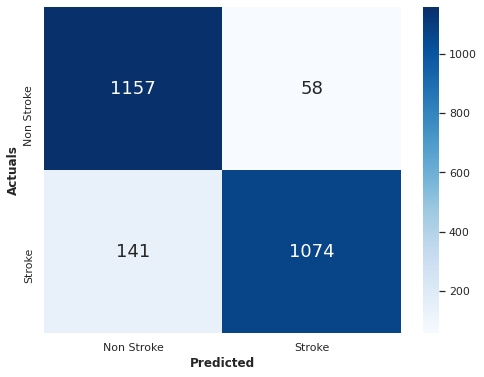

In [ ]:
# Plot the confusion matrix using Seaborn library
# y_test = Actuals, y_pred = Predicted
plt.figure(figsize=(8,6))
class_names = ['Non Stroke','Stroke']
_ = sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, annot_kws={"size": 18},
                cmap=plt.cm.Blues,fmt='.4g',
                xticklabels=class_names, yticklabels=class_names)
_ = plt.ylabel('Actuals', fontweight='bold')
_ = plt.xlabel('Predicted', fontweight='bold')

In [ ]:
models.append('Logistic Regression')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, logreg.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
false_negative_list.append(confusion_matrix(y_test, y_pred)[1,0])

##### Random Forest

In [ ]:
# Random Forest
rf = RandomForestClassifier(n_jobs=-1)

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'n_estimators': [50, 100, 150, 250],
              'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 15, 20],
              'min_samples_split': [2, 3, 5]}

gs_rf = GridSearchCV(rf,
                    param_grid, 
                    cv=5,
                    scoring='f1_macro',
                    #scoring='roc_auc_ovr',
                    n_jobs=-1)
gs_rf.fit(X_train_scaled, y_train)

CPU times: user 5.29 s, sys: 447 ms, total: 5.73 s
Wall time: 4min 51s


In [ ]:
# Best model hyperparameters and score
print(gs_rf.best_estimator_)
print(gs_rf.best_params_)
print(gs_rf.best_score_)

RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=-1)
{'criterion': 'gini', 'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 50}
0.9615876045945969


In [ ]:
# Using best estimator found by GridSearchCV
rf = gs_rf.best_estimator_
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=15, n_estimators=50, n_jobs=-1)

In [ ]:
y_pred = rf.predict(X_test_scaled)

In [ ]:
print("Classification report:")
print()
print(classification_report(y_test, y_pred))
print()

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Classification report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1215
           1       0.98      0.96      0.97      1215

    accuracy                           0.97      2430
   macro avg       0.97      0.97      0.97      2430
weighted avg       0.97      0.97      0.97      2430


Confusion Matrix:


array([[1191,   24],
       [  44, 1171]])

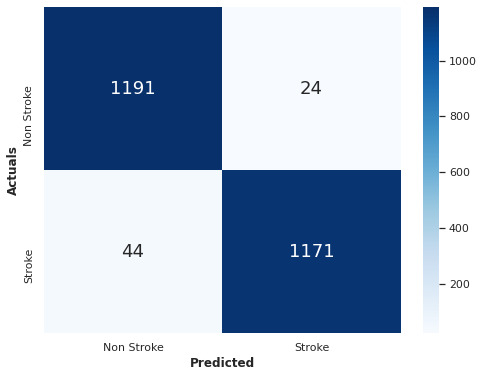

In [ ]:
# Plot the confusion matrix using Seaborn library
# y_test = Actuals, y_pred = Predicted
plt.figure(figsize=(8,6))
class_names = ['Non Stroke','Stroke']
_ = sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, annot_kws={"size": 18},
                cmap=plt.cm.Blues,fmt='.4g',
                xticklabels=class_names, yticklabels=class_names)
_ = plt.ylabel('Actuals', fontweight='bold')
_ = plt.xlabel('Predicted', fontweight='bold')

In [ ]:
models.append('Random Forest')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, rf.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
false_negative_list.append(confusion_matrix(y_test, y_pred)[1,0])

##### Decision Tree

In [ ]:
# Decision Tree

# Import the Decision Tree algorithm
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)

In [ ]:
%%time
# Hyperparameter fine-tuning for Decision Tree on multi-class dataset
# ... via Grid Search method
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [5, 10, 15, 20],
              'min_samples_split': [2, 3, 5]}

gs_dt = GridSearchCV(dt,
                    param_grid, 
                    cv=5,
                    scoring='f1_macro',
                    #scoring='roc_auc_ovr',
                    n_jobs=-1)
gs_dt.fit(X_train_scaled, y_train)

CPU times: user 349 ms, sys: 29.7 ms, total: 379 ms
Wall time: 2.22 s


In [ ]:
# Best model hyperparameters and score
print(gs_dt.best_estimator_)
print(gs_dt.best_params_)
print(gs_dt.best_score_)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=3,
                       random_state=42)
{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 3}
0.9401857548218459


In [ ]:
# Using best estimator found by GridSearchCV
dt = gs_dt.best_estimator_
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_split=3,
                       random_state=42)

In [ ]:
y_pred = dt.predict(X_test_scaled)

In [ ]:
print("Classification report:")
print()
print(classification_report(y_test, y_pred))
print()

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Classification report:

              precision    recall  f1-score   support

           0       0.95      0.94      0.95      1215
           1       0.95      0.95      0.95      1215

    accuracy                           0.95      2430
   macro avg       0.95      0.95      0.95      2430
weighted avg       0.95      0.95      0.95      2430


Confusion Matrix:


array([[1148,   67],
       [  57, 1158]])

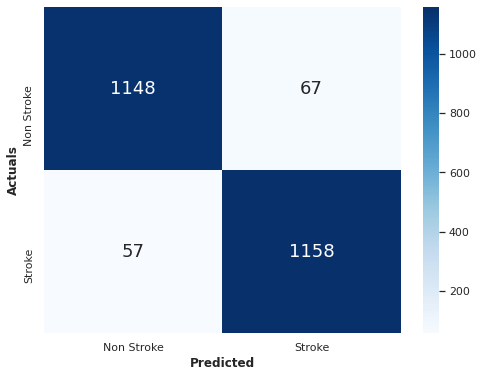

In [ ]:
# Plot the confusion matrix using Seaborn library
# y_test = Actuals, y_pred = Predicted
plt.figure(figsize=(8,6))
class_names = ['Non Stroke','Stroke']
_ = sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, annot_kws={"size": 18},
                cmap=plt.cm.Blues,fmt='.4g',
                xticklabels=class_names, yticklabels=class_names)
_ = plt.ylabel('Actuals', fontweight='bold')
_ = plt.xlabel('Predicted', fontweight='bold')

In [ ]:
models.append('Decision Tree')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, dt.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
false_negative_list.append(confusion_matrix(y_test, y_pred)[1,0])

##### K-nearest Neighbors

In [ ]:
# KNN
# Import the K-Nearest Neighbors algorithm
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}

gs_knn = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    scoring='f1_macro',
                    #scoring='roc_auc_ovr',
                    n_jobs=-1)
gs_knn.fit(X_train_scaled, y_train)

CPU times: user 424 ms, sys: 38.9 ms, total: 463 ms
Wall time: 6.42 s


In [ ]:
# Best model hyperparameters and score
print(gs_knn.best_estimator_)
print(gs_knn.best_params_)
print(gs_knn.best_score_)

KNeighborsClassifier(n_neighbors=2)
{'n_neighbors': 2}
0.9596606023206045


In [ ]:
# Using best estimator found by GridSearchCV
knn = gs_knn.best_estimator_
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=2)

In [ ]:
y_pred = knn.predict(X_test_scaled)

In [ ]:
print("Classification report:")
print()
print(classification_report(y_test, y_pred))
print()

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Classification report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1215
           1       0.98      0.95      0.97      1215

    accuracy                           0.97      2430
   macro avg       0.97      0.97      0.97      2430
weighted avg       0.97      0.97      0.97      2430


Confusion Matrix:


array([[1187,   28],
       [  55, 1160]])

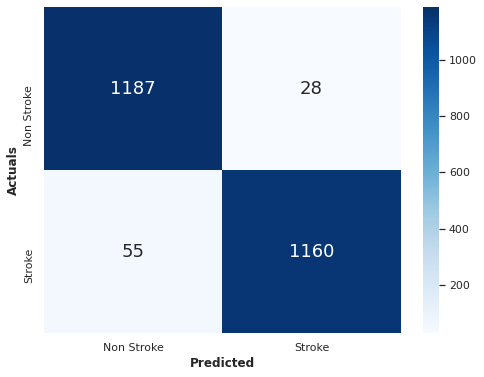

In [ ]:
# Plot the confusion matrix using Seaborn library
# y_test = Actuals, y_pred = Predicted
plt.figure(figsize=(8,6))
class_names = ['Non Stroke','Stroke']
_ = sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, annot_kws={"size": 18},
                cmap=plt.cm.Blues,fmt='.4g',
                xticklabels=class_names, yticklabels=class_names)
_ = plt.ylabel('Actuals', fontweight='bold')
_ = plt.xlabel('Predicted', fontweight='bold')

In [ ]:
models.append('K-nearest Neighbors')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, knn.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
false_negative_list.append(confusion_matrix(y_test, y_pred)[1,0])

##### Support Vector Machine (SVM)

In [ ]:
# LinearSVC
from sklearn.svm import LinearSVC, SVC

svm = LinearSVC()

In [ ]:
%%time
# Hyperparameter tuning using K-fold cross validation
# ... via Grid Search method
param_grid = {'penalty': ['l1', 'l2'],
              'C': np.logspace(-2, 2, 5),
              'max_iter': list(range(500, 3000, 5000))}

gs_svm = GridSearchCV(svm,
                    param_grid, 
                    cv=5,
                    scoring='f1_macro',
                    #scoring='roc_auc_ovr',
                    n_jobs=-1)
gs_svm.fit(X_train_scaled, y_train)

CPU times: user 211 ms, sys: 13.4 ms, total: 225 ms
Wall time: 1.33 s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [       nan 0.91331721        nan 0.91430662        nan 0.91615271
        nan 0.91519536        nan 0.89358386]
  category=UserWarning


In [ ]:
# Best model hyperparameters and score
print(gs_svm.best_estimator_)
print(gs_svm.best_params_)
print(gs_svm.best_score_)

LinearSVC(max_iter=500)
{'C': 1.0, 'max_iter': 500, 'penalty': 'l2'}
0.9161527057688609


In [ ]:
# Using best estimator found by GridSearchCV
svm = gs_svm.best_estimator_
svm.fit(X_train_scaled, y_train)

LinearSVC(max_iter=500)

In [ ]:
y_pred = svm.predict(X_test_scaled)

In [ ]:
print("Classification report:")
print()
print(classification_report(y_test, y_pred))
print()

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Classification report:

              precision    recall  f1-score   support

           0       0.89      0.97      0.93      1215
           1       0.97      0.88      0.92      1215

    accuracy                           0.93      2430
   macro avg       0.93      0.93      0.92      2430
weighted avg       0.93      0.93      0.92      2430


Confusion Matrix:


array([[1178,   37],
       [ 145, 1070]])

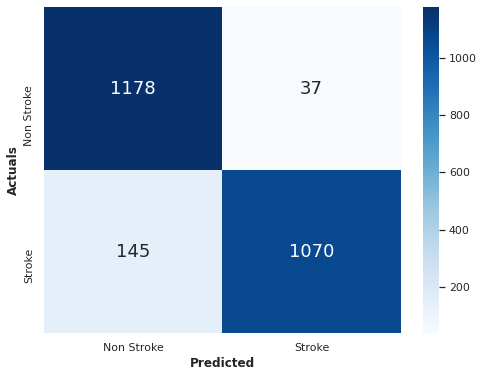

In [ ]:
# Plot the confusion matrix using Seaborn library
# y_test = Actuals, y_pred = Predicted
plt.figure(figsize=(8,6))
class_names = ['Non Stroke','Stroke']
_ = sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, annot_kws={"size": 18},
                cmap=plt.cm.Blues,fmt='.4g',
                xticklabels=class_names, yticklabels=class_names)
_ = plt.ylabel('Actuals', fontweight='bold')
_ = plt.xlabel('Predicted', fontweight='bold')

In [ ]:
models.append('Support Vector Machine')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, svm.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
false_negative_list.append(confusion_matrix(y_test, y_pred)[1,0])

##### Mixed Naive Bayes

In [ ]:
X_train_scaled.columns

Index(['gender', 'age', 'Residence_type', 'avg_glucose_level',
       'work_type_Govt_job', 'work_type_Private', 'work_type_Self-employed',
       'work_type_children', 'smoking_status_Unknown',
       'smoking_status_formerly smoked', 'smoking_status_never smoked',
       'smoking_status_smokes', 'HypTension_HeartDisease'],
      dtype='object')

In [ ]:
# Naive Bayes
from mixed_naive_bayes import MixedNB

# 'MixedNB' object has no attribute 'set_params': no hyperparameter tuning
mnb = MixedNB(categorical_features=[0,2,4,5,6,7,8,9,10,11,12])
#Selection#1 mnb = MixedNB(categorical_features=[3,4,5,6,7])
#Selection#2 mnb = MixedNB(categorical_features=[0,2,5,6,7,8])
mnb.fit(X_train_scaled, y_train)
y_pred = mnb.predict (X_test_scaled)

In [ ]:
print("Classification report:")
print()
print(classification_report(y_test, y_pred))
print()

# Confusion Matrix
print("Confusion Matrix:")
confusion_matrix(y_test, y_pred)

Classification report:

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1215
           1       0.81      0.87      0.84      1215

    accuracy                           0.84      2430
   macro avg       0.84      0.84      0.84      2430
weighted avg       0.84      0.84      0.84      2430


Confusion Matrix:


array([[ 974,  241],
       [ 157, 1058]])

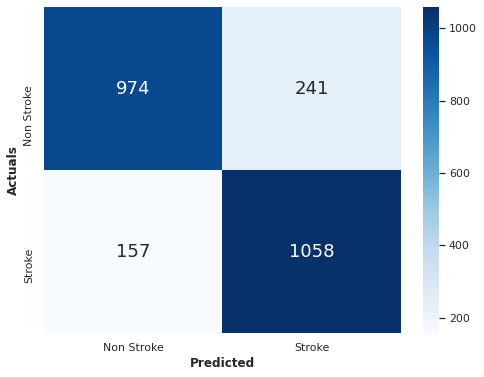

In [ ]:
# Plot the confusion matrix using Seaborn library
# y_test = Actuals, y_pred = Predicted
plt.figure(figsize=(8,6))
class_names = ['Non Stroke','Stroke']
_ = sns.heatmap(confusion_matrix(y_test, y_pred), 
                annot=True, annot_kws={"size": 18},
                cmap=plt.cm.Blues,fmt='.4g',
                xticklabels=class_names, yticklabels=class_names)
_ = plt.ylabel('Actuals', fontweight='bold')
_ = plt.xlabel('Predicted', fontweight='bold')

In [ ]:
models.append('Mixed Naive Bayes')
precision_list.append(precision_score(y_test, y_pred, average='macro'))
recall_list.append(recall_score(y_test, y_pred, average='macro'))
f1_score_list.append(f1_score(y_test, y_pred, average='macro'))
training_acc_list.append(accuracy_score(y_train, mnb.predict(X_train_scaled)))
testing_acc_list.append(accuracy_score(y_test, y_pred))
false_negative_list.append(confusion_matrix(y_test, y_pred)[1,0])

#### Compilation of Model Metrics

In [ ]:
model_metrics = pd.DataFrame(zip(models, training_acc_list, testing_acc_list,
                                 precision_list, recall_list, f1_score_list, false_negative_list), 
                             columns=['Model', 'Training Acc', 'Testing Acc', 'Precision', 'Recall', 'F1 Score', 'False Negative'])

#### Model Performance Summary

In [ ]:
model_metrics.sort_values(by='F1 Score', ascending=False)

,Model,Training Acc,Testing Acc,Precision,Recall,F1 Score,False Negative
1,Random Forest,0.999040,0.972016,0.972144,0.972016,0.972015,44
3,K-nearest Neighbors,0.979973,0.965844,0.966074,0.965844,0.965839,55
2,Decision Tree,0.995336,0.948971,0.949002,0.948971,0.948970,57
4,Support Vector Machine,0.916598,0.925103,0.928488,0.925103,0.924955,145
0,Logistic Regression,0.917147,0.918107,0.920067,0.918107,0.918011,141
5,Mixed Naive Bayes,0.847737,0.836214,0.837829,0.836214,0.836018,157


Based on the table above, Random Forest performs the best!

### Step 4: Predict and Evaluate with the best model

In [ ]:
# Prediction by selected model (Random Forest)
y_pred = rf.predict(X_test_scaled)

In [ ]:
# Classification Report
print("Classification report:")
print()
print(classification_report(y_test,y_pred))

Classification report:

              precision    recall  f1-score   support

           0       0.96      0.98      0.97      1215
           1       0.98      0.96      0.97      1215

    accuracy                           0.97      2430
   macro avg       0.97      0.97      0.97      2430
weighted avg       0.97      0.97      0.97      2430



Text(0.5, 12.5, 'Predicted')

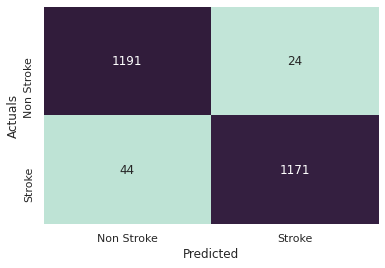

In [ ]:
## Confusion Matrix

conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False, cmap=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True),
          xticklabels=['Non Stroke','Stroke'],
          yticklabels=['Non Stroke','Stroke'] )
plt.ylabel('Actuals')
plt.xlabel('Predicted')

### Step 5: Features importances and Feature Selection

#### Get and plot Features Importance

In [ ]:
# Creating the feature importances dataframe
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=True)

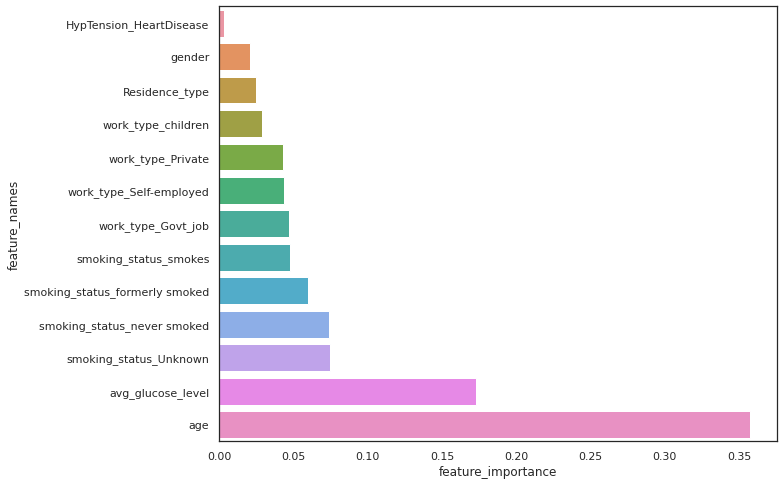

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])

In [ ]:
# Convert 'feat_imp_sorted' from dataframe to a Series
feat_imp_series = feat_imp_sorted['feature_importance'].squeeze()
feat_imp_series.index = feat_imp_sorted['feature_names']

In [ ]:
# let's evaluate the model from dropping zero features to dropping 19 features
# For each step, we will drop the next least important feature based on the sorted 'feat_imp_sorted' 
for i in range(len(feat_imp_series)):
    X_train_corr = X_train_scaled.drop([feat_imp_series.index[idx] for idx in range(i)], axis=1)
    score = rf.fit(X_train_corr, y_train).score(X_train_corr, y_train)
    print('Score for {} features dropped: {:.2%}'.format(i, score))

Score for 0 features dropped: 99.90%
Score for 1 features dropped: 99.93%
Score for 2 features dropped: 99.89%
Score for 3 features dropped: 99.86%
Score for 4 features dropped: 99.88%
Score for 5 features dropped: 99.73%
Score for 6 features dropped: 99.73%
Score for 7 features dropped: 99.77%
Score for 8 features dropped: 99.03%
Score for 9 features dropped: 98.82%
Score for 10 features dropped: 98.19%
Score for 11 features dropped: 98.77%
Score for 12 features dropped: 93.05%


In [ ]:
# Let's evaluate the model using SelectKBest to select the top 1 feature up till selecting all 19 features
from sklearn.feature_selection import SelectKBest, chi2, f_regression
# For classifications, use 'chi2' score function
# For regressions, use 'f_regression' score function
for k in range(1,len(feat_imp_series)+1):
    selectClf = SelectKBest(chi2, k=k)
    X_train_Ksel = selectClf.fit_transform(X_train_scaled, y_train)
    score = rf.fit(X_train_Ksel, y_train).score(X_train_Ksel, y_train)
    print('Score for {} features selected: {:.2%}'.format(k, score))

Score for 1 features selected: 63.18%
Score for 2 features selected: 63.91%
Score for 3 features selected: 68.42%
Score for 4 features selected: 75.78%
Score for 5 features selected: 93.35%
Score for 6 features selected: 94.05%
Score for 7 features selected: 94.83%
Score for 8 features selected: 95.49%
Score for 9 features selected: 97.00%
Score for 10 features selected: 99.89%
Score for 11 features selected: 99.86%
Score for 12 features selected: 99.95%
Score for 13 features selected: 99.84%


When we compare both approaches at k=15 for SelectKBest and dropping the 4 least important features for manual method, it appears to converge to the same selection.

#### Feature Selection by SelectKBest
We can also use SelectKBest from scikit-learn library to help us select the top-k most important features.

In [ ]:
selectClf = SelectKBest(chi2, k=13)
X_train_Ksel = selectClf.fit_transform(X_train_scaled, y_train)

In [ ]:
mask = selectClf.get_support() #list of booleans
feature_names = list(X_train_scaled.columns.values)
new_features = [] # The list of your K best features

for booltype, feature in zip(mask, feature_names):
    if booltype:
        new_features.append(feature)

In [ ]:
# Feature Selection by SelectKBest(13)
new_features

['gender',
 'age',
 'Residence_type',
 'avg_glucose_level',
 'work_type_Govt_job',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'smoking_status_Unknown',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes',
 'HypTension_HeartDisease']

### Step 7: Comparison of Results

#### F1-Score Comparison

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


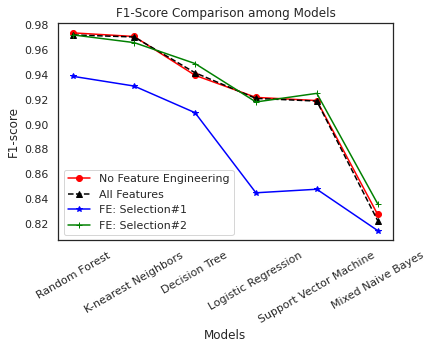

In [ ]:
import matplotlib.pyplot as plt
   
Models = ["Random Forest","K-nearest Neighbors","Decision Tree","Logistic Regression","Support Vector Machine","Mixed Naive Bayes"]
f1_score = [0.973660,0.970776,0.939503,0.921703,0.919144,0.827411]
f1_score_FE0 = [0.972014,0.970364,0.941555,0.920879,0.918722,0.822456]
f1_score_FE1 = [0.938625,0.930837,0.909376,0.844844,0.847699,0.814406]
f1_score_FE2 = [0.972015,0.965839,0.948970,0.918011,0.924955,0.836018]

plt.plot(Models, f1_score, color='red', marker='o')
plt.plot(Models, f1_score_FE0, color='black', marker='^',linestyle='dashed')
plt.plot(Models, f1_score_FE1, color='blue', marker='*')
plt.plot(Models, f1_score_FE2, color='green', marker='+')
plt.title('F1-Score Comparison among Models')
ax=plt.subplot()
ax.set_xticklabels(Models,rotation=30)
plt.xlabel('Models')
plt.ylabel('F1-score')
plt.legend(['No Feature Engineering','All Features','FE: Selection#1','FE: Selection#2'])
plt.show()

#### False Negative Comparison

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


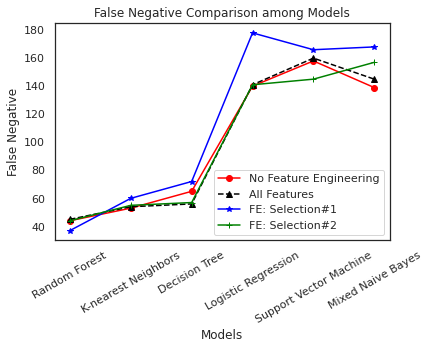

In [ ]:
import matplotlib.pyplot as plt
   
Models = ["Random Forest","K-nearest Neighbors","Decision Tree","Logistic Regression","Support Vector Machine","Mixed Naive Bayes"]
fneg = [44,53,65,140,158,139]
fneg_FE0 = [45,54,56,141,160,145]
fneg_FE1 = [37,60,72,178,166,168]
fneg_FE2 = [44,55,57,141,145,157]

plt.plot(Models, fneg, color='red', marker='o')
plt.plot(Models, fneg_FE0, color='black', marker='^',linestyle='dashed')
plt.plot(Models, fneg_FE1, color='blue', marker='*')
plt.plot(Models, fneg_FE2, color='green', marker='+')
plt.title('False Negative Comparison among Models')
ax=plt.subplot()
ax.set_xticklabels(Models,rotation=30)
plt.xlabel('Models')
plt.ylabel('False Negative')
plt.legend(['No Feature Engineering','All Features','FE: Selection#1','FE: Selection#2'])
plt.show()